# Thyroid Analysis

In [1]:
!pip install pynrrd

In [1]:
import cv2
import numpy as np
import nrrd
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## 1. NRRD Files

In [2]:
# Set the directory you want to list files from
directory = 'dataUSGthyroid/SAMSUNG'

# Use the glob module to create a list of file paths
images_paths = sorted(glob.glob(directory + '/images' + '**/*', recursive=True))
contoures_paths = sorted(glob.glob(directory + '/masks' + '**/*', recursive=True))

In [3]:
images_paths[:10]

['dataUSGthyroid/SAMSUNG/images/109800_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1104018_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1109437_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/11276_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1127758_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1129218_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1155158_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1186918_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/1212278_image.nrrd',
 'dataUSGthyroid/SAMSUNG/images/121857_image.nrrd']

In [4]:
contoures_paths[:10]

['dataUSGthyroid/SAMSUNG/masks/109800_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1104018_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1109437_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/11276_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1127758_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1129218_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1155158_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1186918_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/1212278_label.nrrd',
 'dataUSGthyroid/SAMSUNG/masks/121857_label.nrrd']

In [142]:
# Read the NRRD file
nrrd_data, header = nrrd.read(images_paths[220])

# Print the NRRD header
print(header)

# Access the data from the NRRD file
# print(nrrd_data)

OrderedDict([('type', 'uint8'), ('dimension', 3), ('sizes', array([614, 816,   3])), ('encoding', 'gzip')])


In [143]:
nrrd_data.shape

(614, 816, 3)

In [144]:
header

OrderedDict([('type', 'uint8'),
             ('dimension', 3),
             ('sizes', array([614, 816,   3])),
             ('encoding', 'gzip')])

In [145]:
len(contoures_paths)

606

In [ ]:
X_MARGIN = 1
Y_MARGIN = 30

i = 120

print(images_paths[i])
print(contoures_paths[i])

# Read images
image1, header = nrrd.read(images_paths[i])
image2, header = nrrd.read(contoures_paths[i])

# image1 = image1[X_MARGIN:-X_MARGIN, Y_MARGIN:-Y_MARGIN]
# image2 = image2[X_MARGIN:-X_MARGIN, Y_MARGIN:-Y_MARGIN]

fig = plt.figure(figsize=(15, 15))

# Create a single subplot
ax = plt.subplot()

ax.imshow(image1)

min_x, max_x = 190, 1080
min_y, max_y = 125, 760

ax.plot([min_x, min_x], [min_y, max_y], color='red', linewidth=2)
ax.plot([max_x, max_x], [min_y, max_y], color='red', linewidth=2)

ax.plot([min_x, max_x], [min_y, min_y], color='red', linewidth=2)
ax.plot([min_x, max_x], [max_y, max_y], color='red', linewidth=2)
ax.imshow(image2, alpha=0.1)

# Show the figure
plt.show()

In [29]:
def cut_image_and_mask(image, mask, min_x, max_x, min_y, max_y):
    cut_image = image[min_y:max_y, min_x:max_x] 
    cut_mask = mask[min_y:max_y, min_x:max_x] 
    return cut_image, cut_mask

def get_new_path(old_path, new_dir='samsung_processed'):
    path = old_path.split('/')
    path[1] = new_dir
    path = '/'.join(path)
    return path

In [148]:
get_new_ge_path(images_paths[0])

'dataUSGthyroid/GE_processed/images/1006092_image.nrrd'

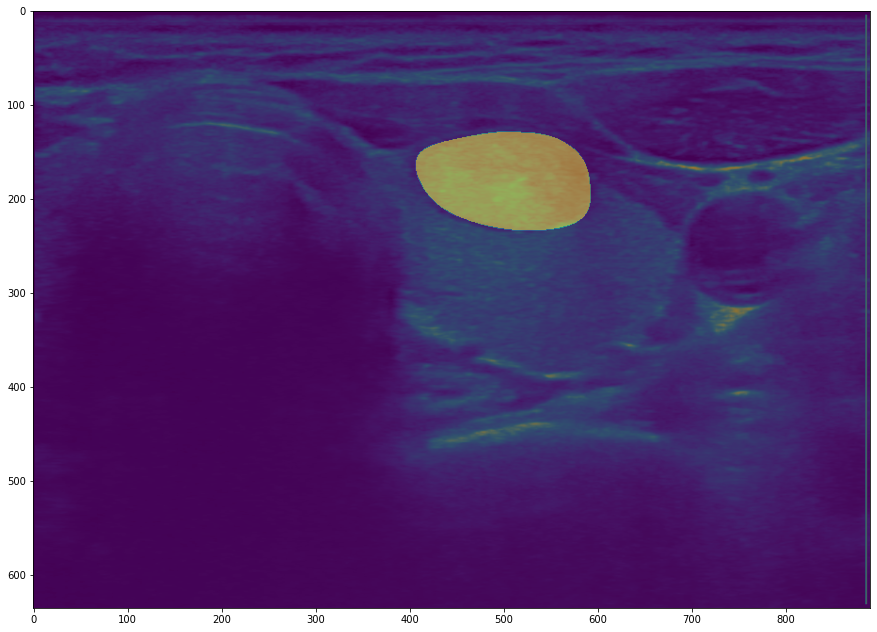

In [27]:
cut_image, cut_mask = cut_image_and_mask(image1, image2, 190, 1080, 125, 760)

fig = plt.figure(figsize=(15, 15))

# Create a single subplot
ax = plt.subplot()
ax.imshow(cut_image)
ax.imshow(cut_mask, alpha=0.5)
plt.show()

In [31]:
for image_path, mask_path in zip(images_paths, contoures_paths):
    image, header = nrrd.read(image_path)
    mask, header = nrrd.read(mask_path)
    
    cut_image, cut_mask = cut_image_and_mask(image, mask, 190, 1080, 125, 760)
    new_image_path = get_new_path(image_path)
    new_mask_path = get_new_path(mask_path)
    
    cut_image = np.expand_dims(cut_image, 2)
    cut_mask = np.expand_dims(cut_mask, 2)
    
    nrrd.write(new_image_path, cut_image)
    nrrd.write(new_mask_path, cut_mask)

## Test

In [210]:
import glob
import nrrd
import random
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

SAMSUNG_MASK_NORM = 15555.0
GA_MASK_NORM = 255.0


class UltraSoundImages(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, raw_images_paths, raw_masks_paths, dataset_type='ge', augment=True, random_crop=False, size=None):
        self.MAX_SHARPNESS_LEVEL = 5
        self.MIN_CONTRAST_ADJUSTMENT = 0
        self.MAX_CONTRAST_ADJUSTMENT = 2.5
        self.MAX_NOISE_SCALE = 4
        self.ROTATION_RANGE = 15
        
        self.random_crop = random_crop
        self.batch_size = batch_size
        self.augment = augment
        self.images = []
        self.masks = []
        self.dataset_type = dataset_type
        
        if self.dataset_type == 'samsung':
            self.mask_normalizer = SAMSUNG_MASK_NORM
        else:
            self.mask_normalizer = GA_MASK_NORM

        self.miscellaneous_process = [
            self.sharpen,
            self.adjust_contrast,
            self.adjust_brightness,
            self.add_noise,
            self.gaussian_filter,
        ]
        
        # Image and mask have to be stacked
        self.geometric_process = [
            self.zoom,
            self.flip,
            self.rotate, 
            self.shear,
            # self.random_crop,
        ]
        
        
        print('Loading images from NRRD format and resizing')
        for i in range(len(raw_images_paths)):
            image, header = nrrd.read(raw_images_paths[i])
            mask, header = nrrd.read(raw_masks_paths[i])
            
            if size and not self.random_crop:
                image = tf.image.resize_with_pad(image, size[0], size[1])
                mask = tf.image.resize_with_pad(mask, size[0], size[1])
                
            if self.dataset_type=='ge':
                image = np.expand_dims(image[:,:,0], 2)
                mask = np.expand_dims(mask[:,:,0] , 2)
            
            # self.images.append(tf.convert_to_tensor(list(image)) / 255 )
            # self.masks.append(tf.convert_to_tensor(list(mask)) / 255)
            
            self.images.append(image)
            self.masks.append(mask)
        print('Finished loading')

    def __len__(self):
        return len(self.masks) // self.batch_size
    
    def __getitem__(self, idx, augment=True):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        output_images = self.images[i : i + self.batch_size]
        output_masks = self.masks[i : i + self.batch_size]
        
        if self.augment and augment:
            output_images, output_masks = self._augment_batch(output_images, output_masks)
        
        return np.array(output_images) / 255, np.array(output_masks) / self.mask_normalizer
    
    def show_sample(self):
        images, masks = self.__getitem__(0)

        i = 0
        plt.figure(figsize=(15, 15))
        for image, mask in zip(images, masks):
            plt.subplot(2, 2, i + 1)
            plt.imshow(image)
            plt.imshow(mask, alpha=0.5)
            plt.axis('off')
            i+=1
        plt.show()
        
    def test_augmentation(self, show_mask=True):
        images, masks = self.__getitem__(0)
        
        image, mask = images[0], masks[0]
        org_image = np.array(image, copy=True)
        org_mask = np.array(mask, copy=True)
        aug_image, aug_mask = self._augment(image, mask)
        
        plt.figure(figsize=(15,15))
        plt.subplot(2,1,1)
        plt.imshow(org_image)
        if show_mask:
            plt.imshow(org_mask, alpha=0.5)
        plt.subplot(2,1,2)
        plt.imshow(aug_image)
        if show_mask:
            plt.imshow(aug_mask, alpha=0.5)
        plt.axis('off')
        plt.show()
    
    
    def _augment_batch(self, images, masks):
        for i in range(len(images)):
            images[i], masks[i] = self._augment(images[i], masks[i])
        return images, masks
    
    def _augment(self, image, mask):
        
        # TODO -> Chose random proc from misc
        # And then perform all geo procs
        # for proc in self.miscellaneous_process:
        #     image, mask = proc(image, mask)
            
#         misc_proc = random.choice(self.miscellaneous_process)
#         image, mask = misc_proc(image, mask)
            
        image, mask = np.array(image), np.array(mask)
        stacked = tf.stack([image.squeeze(), mask.squeeze()])
        for proc in self.geometric_process:
            stacked = proc(stacked)
            
        stacked = np.expand_dims(stacked, 3)
        return stacked
        return tf.unstack(stacked, axis=2)
    
    # MIDCELLANEOUS TRANSFORMATIONS
    def sharpen(self, image, mask):
        level = random.random() * self.MAX_SHARPNESS_LEVEL
        sharpened = tfa.image.sharpness(image, level)
        return sharpened, mask
    
    def adjust_contrast(self, image, mask):
        adjusted = tf.image.random_contrast(image, self.MIN_CONTRAST_ADJUSTMENT, self.MAX_CONTRAST_ADJUSTMENT)
        return adjusted, mask
    
    def adjust_brightness(self, image, mask):
        level = random.random() * 0.5 - 0.1
        bright = tf.image.adjust_brightness(image, level)
        return bright, mask
    
    def add_noise(self, image, mask):
        noise = np.random.normal(size=image.shape, scale=self.MAX_NOISE_SCALE)
        return image+noise, mask
    
    def gaussian_filter(self, image, mask):
        filtered = tfa.image.gaussian_filter2d(image)
        return filtered, mask

    
    # GEOMETRIC
    def flip(self, stacked):
        stacked = tf.stack(tf.unstack(stacked, axis=0), axis=2)
        
        stacked = tf.image.random_flip_left_right(stacked)
        stacked = tf.image.random_flip_up_down(stacked)
        
        stacked = tf.stack(tf.unstack(stacked, axis=2))
        return stacked
    
    def rotate(self, stacked):
        rotated = tf.keras.preprocessing.image.random_rotation(
            stacked,
            self.ROTATION_RANGE,
            fill_mode='constant',
        )
        return rotated
    
    def zoom(self, stacked):
        zoomed = tf.keras.preprocessing.image.random_zoom(
            stacked,
            # 1.5,
            [0.8, 1.2],
            fill_mode='constant',
        )
        return zoomed
    
    def shear(self, stacked):
        sheard = tf.keras.preprocessing.image.random_shear(
            stacked,
            10,
            fill_mode='constant',
        )
        return sheard
    
    # Probably not needed anymore, since other methods perform similar task
    def random_crop(self, image, mask):
        stacked_image = tf.stack([image, mask], axis=0)
        cropped_image = tf.image.random_crop(stacked_image, size=[2, 450, 450, 1])
        cropped_image, cropped_mask = cropped_image
        return cropped_image, cropped_mask

def get_dataset(dataset_type, batch_size, image_gen_shape, augment):
  
    # Prepare data generator
    if dataset_type == 'ge':    
        raw_dir = "dataUSGthyroid/GE_processed"
    elif dataset_type == 'samsung':
        raw_dir = "dataUSGthyroid/samsung_processed"
    else:
        raise Exception('Sorry, there is no dataset type called: ' + dataset_type)
        
    raw_masks = raw_dir + "/masks"
    raw_images = raw_dir + "/images"
    raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))[:100]
    raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))[:100]
    print(raw_images_paths[0])
    
    TEST_LEN = 5
    VAL_LEN = 40
    TRAIN_LEN = len(raw_images_paths) - VAL_LEN - TEST_LEN
        
    train_images = raw_images_paths[:TRAIN_LEN]
    validation_images = raw_images_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
    test_images =  raw_images_paths[-TEST_LEN:]

    train_masks = raw_masks_paths[:TRAIN_LEN]
    validation_masks = raw_masks_paths[-(VAL_LEN+TEST_LEN):-TEST_LEN]
    test_masks =  raw_masks_paths[-TEST_LEN:]

    train_gen = UltraSoundImages(batch_size, train_images, train_masks, size=image_gen_shape, dataset_type=dataset_type, augment=augment)
    val_gen = UltraSoundImages(batch_size, validation_images, validation_masks, size=image_gen_shape, dataset_type=dataset_type, augment=augment)
    test_gen = UltraSoundImages(batch_size, test_images, test_masks, size=image_gen_shape, dataset_type=dataset_type, augment=augment)
    
    return train_gen, val_gen, test_gen

In [211]:
augment = True
image_input_shape = (256, 256, 1)
image_gen_shape = (image_input_shape[0], image_input_shape[1])
train_gen, val_gen, test_gen = get_dataset('ge', 4, image_gen_shape, augment)

dataUSGthyroid/GE_processed/images/1006092_image.nrrd
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading
Loading images from NRRD format and resizing
Finished loading


In [193]:
np.subtract(np.array([1,2,3]), np.array([1,1,1]))

array([0, 1, 2])

4


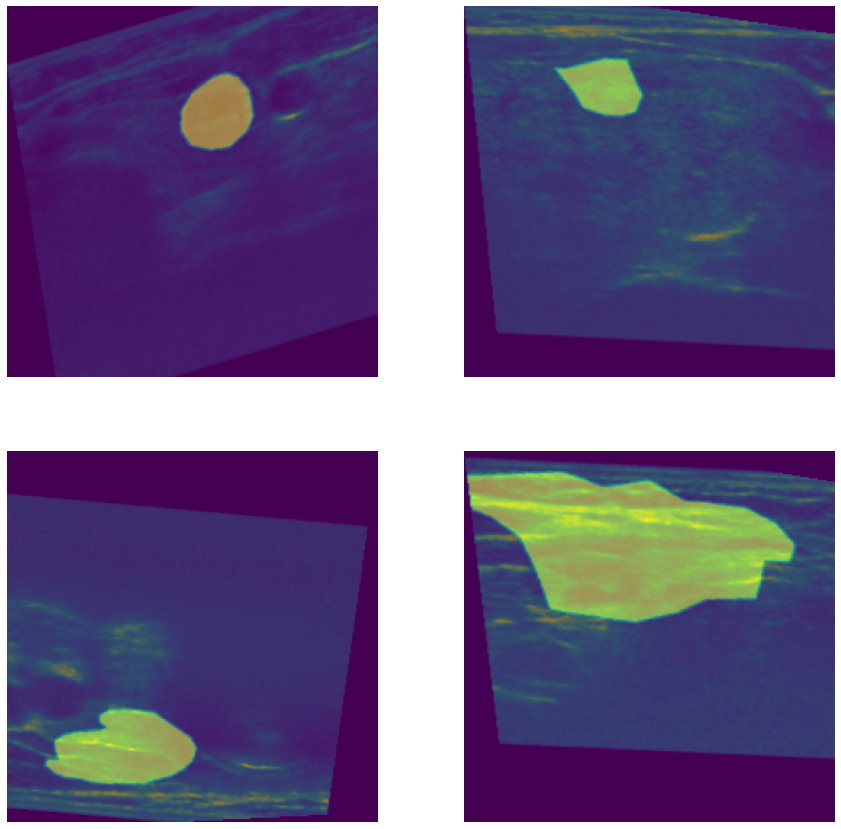

In [212]:
images, masks = test_gen.__getitem__(0)
print(len(images))
i = 0
plt.figure(figsize=(15, 15))
for image, mask in zip(images, masks):
    plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    i+=1
plt.show()

In [213]:
images.shape

(4, 256, 256, 1)

### Detect lines

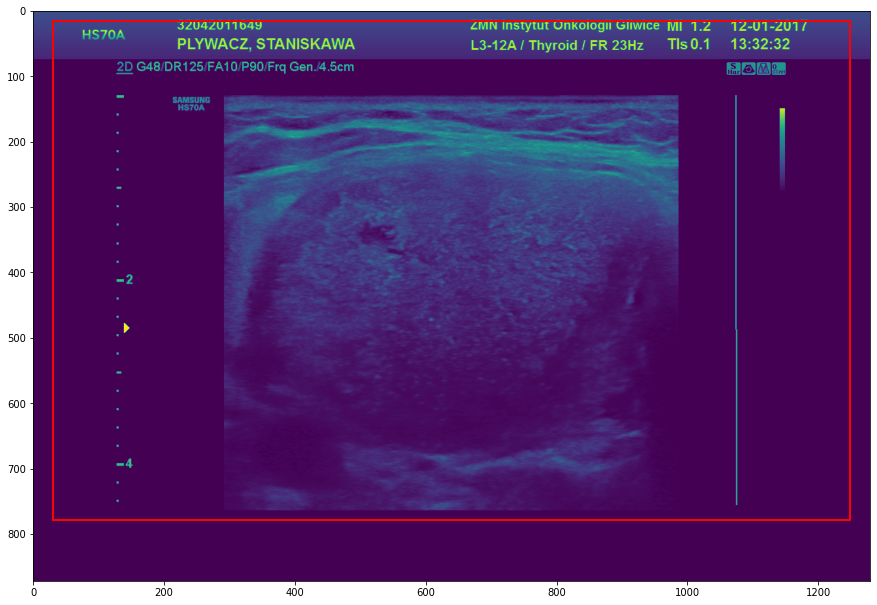

In [26]:
def detect_image_frame(image, margin_x=140, margin_y=80):
    
    X_MARGIN = 15
    Y_MARGIN = 30
    
    image = image[X_MARGIN:-50, Y_MARGIN:-Y_MARGIN]

    # Apply edge detection to the grayscale image
    edges = cv2.Canny(image, 50, 100)

    # Use the HoughLinesP function to detect lines in the image
    lines = cv2.HoughLinesP(edges, 2, np.pi/180, 50, minLineLength=5, maxLineGap=10)
    vertical_lines = []

    xs = []
    ys = []

    # Iterate over the detected lines
    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Filter out lines that are not vertical
        if x1 != x2 and y1 != y2:
            continue

        xs.append(x1)
        xs.append(x2)

        ys.append(y1)
        ys.append(y2)

        # Filter out lines that are not long enough
        if abs(y1 - y2) < 200:
            continue

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    # return min_x + margin_x, max_x - margin_x, min_y + margin_y, max_y - margin_y
    return min_x+Y_MARGIN, max_x+Y_MARGIN, min_y+X_MARGIN, max_y+Y_MARGIN

# Read the image
image, header = nrrd.read(images_paths[0])

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot()
ax.imshow(image)

min_x, max_x, min_y, max_y = detect_image_frame(image)

ax.plot([min_x, min_x], [min_y, max_y], color='red', linewidth=2)
ax.plot([max_x, max_x], [min_y, max_y], color='red', linewidth=2)

ax.plot([min_x, max_x], [min_y, min_y], color='red', linewidth=2)
ax.plot([min_x, max_x], [max_y, max_y], color='red', linewidth=2)

plt.show()

In [18]:
header

OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('sizes', array([360, 560])),
             ('encoding', 'gzip')])

In [19]:
image.shape

(360, 560)

In [20]:
cropped_image = image[min_y:max_y, min_x:max_x]

In [21]:
cropped_image.shape

(304, 487)

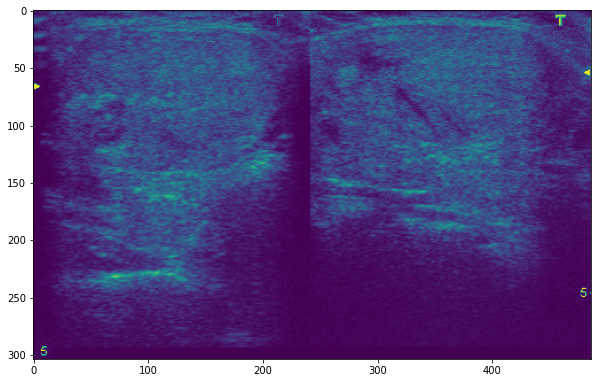

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.imshow(cropped_image)
plt.show()

### Process Images

In [23]:
len(images_paths)

480

In [24]:
def extract_raw_images(images_paths, contoures_paths, save=True, resize='padding'):
    points = []
    full_images = []
    images = []
    masks = []
    failed = []
    
    for i in range(len(images_paths)):

        image, header = nrrd.read(images_paths[i])
        contour, header = nrrd.read(contoures_paths[i])

        try:
            min_x, max_x, min_y, max_y = detect_image_frame(image)
        except:
            failed.append(i)
            continue

        num = (max_x-min_x)
        den = (max_y-min_y)

        if den == 0:
            failed.append(i)
            continue

        ratio = num / den 

        if ratio > 3 or ratio < 0.33:
            failed.append(i)
            continue

        try:
            cropped_image = image[min_y:max_y, min_x:max_x]
            cropped_contour = contour[min_y:max_y, min_x:max_x]

            cropped_image = cropped_image[..., np.newaxis]
            cut_image = tf.image.resize(cropped_image, (512, 512))
            padded_image = tf.image.resize_with_pad(cropped_image, 512, 512)

            cropped_contour = cropped_contour[..., np.newaxis]
            cut_contour = tf.image.resize(cropped_contour, (512, 512))
            padded_contour = tf.image.resize_with_pad(cropped_contour, 512, 512)

            images.append(cropped_image)
            masks.append(cropped_contour)
            full_images.append(image)
            points.append([min_x, max_x, min_y, max_y])
        except:
            continue
            
    
    images = np.array(images)
    masks = np.array(masks)
    full_images = np.array(full_images)
    points = np.array(points)
    
    return images, masks, full_images, points
        

In [25]:
images, masks, full_images, points = extract_raw_images(images_paths,contoures_paths)

/home/sciemala/thyroid_analysis/.env/lib64/python3.6/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/sciemala/thyroid_analysis/.env/lib64/python3.6/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
print(images.shape)
print(masks.shape)
print(full_images.shape)
print(points.shape)

(480,)
(480,)
(480, 360, 560)
(480, 4)


In [45]:
images, masks = [], []

# Set the directory path
raw_dir = "dataUSGthyroid/samsung_processed"
raw_images = raw_dir + "/images"
raw_masks = raw_dir + "/masks"

i = 0
for image_path, mask_path in zip(images_paths, contoures_paths):
    image, header = nrrd.read(image_path)
    mask, header = nrrd.read(mask_path)
    
    image = np.expand_dims(np.array(image[130:-110, 290:-294]), 2)
    mask = np.expand_dims(np.array(mask[130:-110, 290:-294]), 2)
    
    nrrd.write(f'{raw_images}/{i}.nrrd', image)
    nrrd.write(f'{raw_masks}/{i}.nrrd', mask)
    i+=1

In [34]:
image.shape

(632, 696)

In [10]:
image = images[0]
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot()
ax.imshow(image)
plt.show()

NameError: name 'images' is not defined

In [4]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from math import ceil

COLS, ROWS = 4, 9
N_SUB = COLS * ROWS
N_TABS = ceil(len(images) / N_SUB)

In [28]:
%matplotlib inline

# N_TABS = 2

outs = [widgets.Output() for i in range(N_TABS)]
tab = widgets.Tab(children = outs)
for i in range(len(outs)): tab.set_title(i, str(i))
display(tab)

nth_image = 0
for n_tab, out in enumerate(outs):
    with out:
        fig, axs = plt.subplots(ROWS, COLS, figsize=(25, 25))
        sub_images = full_images[n_tab*N_SUB:(n_tab+1)*N_SUB]
        sub_points = points[n_tab*N_SUB:(n_tab+1)*N_SUB]
        for i, ax in enumerate(axs.flat):
            ax.imshow(sub_images[i])
            min_x, max_x, min_y, max_y = sub_points[i]

            ax.plot([min_x, min_x], [min_y, max_y], color='red', linewidth=2)
            ax.plot([max_x, max_x], [min_y, max_y], color='red', linewidth=2)

            ax.plot([min_x, max_x], [min_y, min_y], color='red', linewidth=2)
            ax.plot([min_x, max_x], [max_y, max_y], color='red', linewidth=2)
            
            # ax.title(str(nth_image))
            
            if i == len(sub_images)-1 and n_tab == N_TABS-1: break
        plt.show()

In [5]:
%matplotlib inline

outs = [widgets.Output() for i in range(N_TABS)]
tab = widgets.Tab(children = outs)
for i in range(len(outs)): tab.set_title(i, str(i))
display(tab)

for n_tab, out in enumerate(outs):
    with out:
        fig, axs = plt.subplots(ROWS, COLS, figsize=(25, 25))
        sub_images = images[n_tab*N_SUB:(n_tab+1)*N_SUB]
        sub_masks = masks[n_tab*N_SUB:(n_tab+1)*N_SUB]
        for i, ax in enumerate(axs.flat):
            ax.imshow(sub_images[i])
            ax.imshow(sub_masks[i], alpha=0.5)
            
            if i == len(sub_images)-1 and n_tab == N_TABS-1: break
        plt.show()

## Save

In [10]:
# Set the directory path
raw_dir = "RawUSGimagesNRRD"
raw_images = raw_dir + "/data_output"
raw_masks = raw_dir + "/masks"

In [98]:
if not os.path.exists(raw_dir):
    os.makedirs(raw_dir)

if not os.path.exists(raw_images):
    os.makedirs(raw_images)

if not os.path.exists(raw_masks):
    os.makedirs(raw_masks)

In [2]:
raw_masks

'RawUSGimagesNRRD/masks'

In [101]:
for i in range(len(images)):    
    nrrd.write(f'{raw_images}/{i}.nrrd', images[i])
    nrrd.write(f'{raw_masks}/{i}.nrrd', masks[i])

## 2. Create Tensorflow Dataset

In [2]:
from tensorflow.keras.utils import Sequence

In [11]:
raw_images_paths = sorted(glob.glob(raw_images + '**/*', recursive=True))
raw_masks_paths = sorted(glob.glob(raw_masks + '**/*', recursive=True))

In [19]:
raw_images = []
raw_masks = []

In [20]:
for i in range(len(raw_images_paths)):
    raw_image, header = nrrd.read(raw_images_paths[i])
    raw_mask, header = nrrd.read(raw_masks_paths[i])
    
    raw_images.append(raw_image)
    raw_masks.append(raw_mask)

In [14]:
from tensorflow.image import random_crop

In [51]:
def visualize(org_imge, org_mask, aug_image, aug_mask):
    fig = plt.figure(figsize=(12, 12))
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_imge)
    plt.imshow(org_mask, alpha=0.5)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_image)
    plt.imshow(aug_mask, alpha=0.5)

In [41]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [45]:
image = tf.image.resize_with_pad(raw_images[0], IMG_WIDTH, IMG_HEIGHT)
mask = tf.image.resize_with_pad(raw_masks[0], IMG_WIDTH, IMG_HEIGHT)

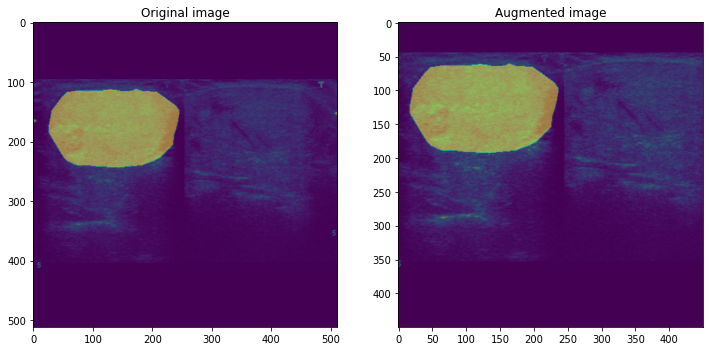

In [68]:
stacked_image = tf.stack([image, mask], axis=0)
cropped_image = tf.image.random_crop(stacked_image, size=[2, 450, 450, 1])
cropped_image, cropped_mask = cropped_image
visualize(image, mask, cropped_image, cropped_mask)

In [26]:
class UltraSoundImages(Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, raw_images_paths, raw_masks_paths, size=None):
        self.batch_size = batch_size
        self.images = []
        self.masks = []
        
        for i in range(len(raw_images_paths)):
            image, header = nrrd.read(raw_images_paths[i])
            mask, header = nrrd.read(raw_masks_paths[i])
            
            if size:
                image = tf.image.resize_with_pad(image, size[0], size[1])
                mask = tf.image.resize_with_pad(mask, size[0], size[1])
            
            self.images.append(tf.convert_to_tensor(list(image)))
            self.images.append(tf.convert_to_tensor(list(mask)))

    def __len__(self):
        return len(self.masks) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        output_images = self.images[i : i + self.batch_size]
        output_masks = self.masks[i : i + self.batch_size]
        
        return np.array(output_images), np.array(output_masks)

In [27]:
train_gen = UltraSoundImages(4, raw_images_paths, raw_masks_paths, size=(512,512))

In [28]:
train_gen.__getitem__(0)[0].shape

(4, 512, 512, 1)

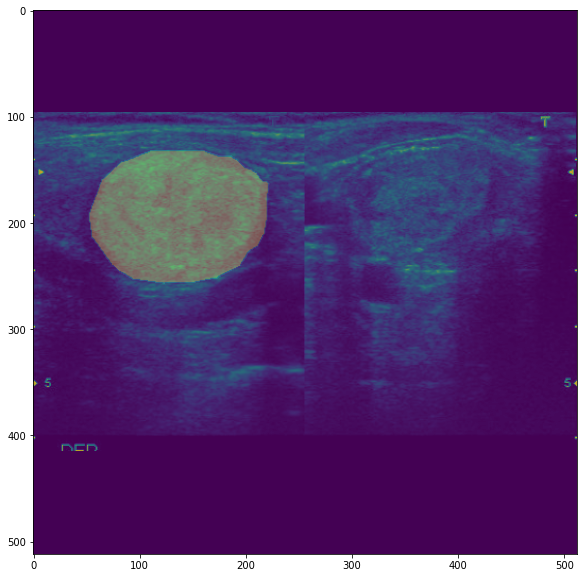

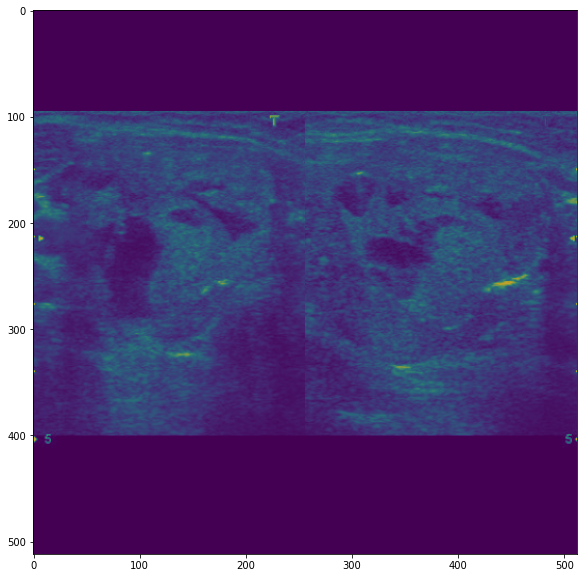

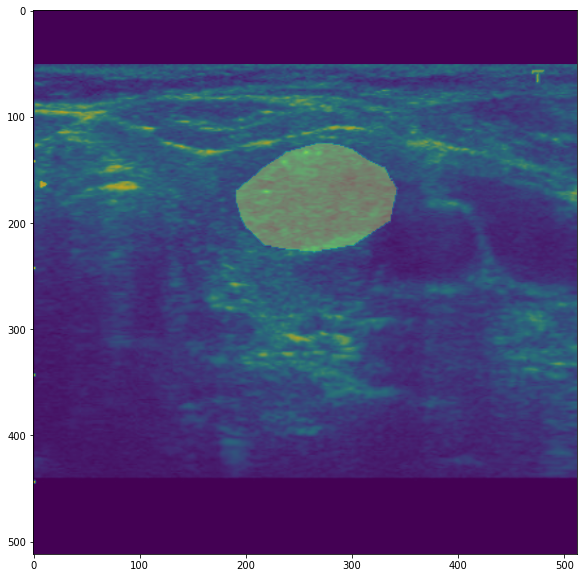

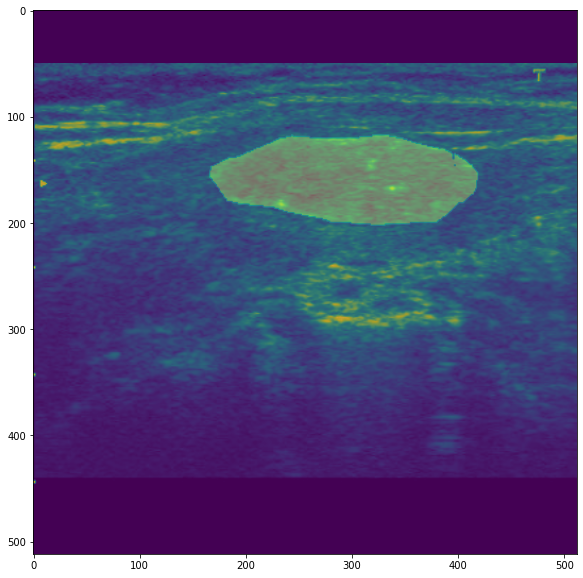

In [13]:
images, masks = train_gen.__getitem__(1)

# Iterate over the dataset and print the element
for image, mask in zip(images, masks):
    fig = plt.figure(figsize=(10, 10))

    # Create a single subplot
    ax = plt.subplot()

    ax.imshow(image)
    ax.imshow(mask, alpha=0.3)
    
fig, axs = plt.subplots(ROWS, COLS, figsize=(25, 25))
        sub_images = images[n_tab*N_SUB:(n_tab+1)*N_SUB]
        sub_masks = masks[n_tab*N_SUB:(n_tab+1)*N_SUB]
        for i, ax in enumerate(axs.flat):
            ax.imshow(sub_images[i])
            ax.imshow(sub_masks[i], alpha=0.5)

# Show the figure
plt.show()

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((raw_images, raw_masks))

In [35]:
dataset.element_spec

(TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(512, 512, 1), dtype=tf.float32, name=None))

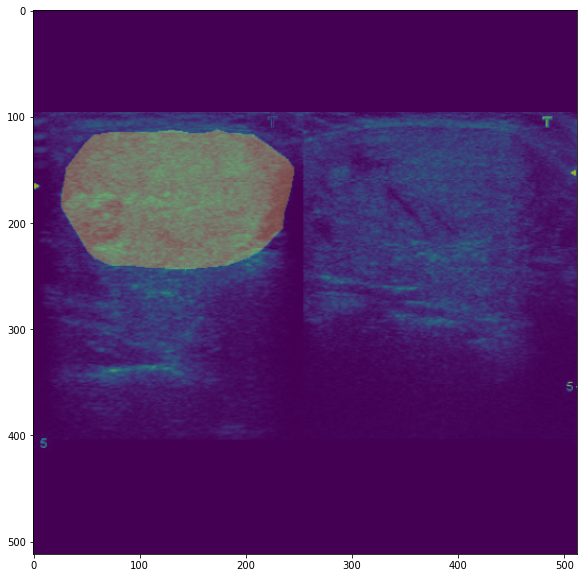

In [46]:
# Create a dataset with the first 10 elements
num_elements = 10
taken_dataset = dataset.take(num_elements)

# Iterate over the dataset and print the elements
for image, mask in taken_dataset.take(1):
    fig = plt.figure(figsize=(10, 10))

    # Create a single subplot
    ax = plt.subplot()

    ax.imshow(image)
    ax.imshow(mask, alpha=0.3)

# Show the figure
plt.show()

In [57]:
X_train, y_train = [], []
for image, mask in dataset.take(16):
    X_train.append(image)
    y_train.append(mask)

In [59]:
np.array(y_train).shape

(16, 512, 512, 1)

### Create a model

In [19]:
from models import unet_model

In [20]:
unet = unet_model((None,None,1), 1)
unet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 256)   295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 256)   0     

### Compile model

In [21]:
unet.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Create Callbacks

In [22]:
# Create the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

### Train

In [23]:
# Train the model with the EarlyStopping callback
history = unet.fit(train_gen, epochs=10, batch_size=16, callbacks=[early_stopping])

/home/sciemala/thyroid_analysis/.env/lib64/python3.6/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

### History

In [ ]:
def plot_history(history):
    # Extract the history values
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']

    # Plot the loss values
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # Plot the accuracy values
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [ ]:
plot_history(history)